### First raw analysis

In [1]:
%run 60_testing_different_sf.ipynb

data_folder = ../Psychopy_data/pilot/sf_0
Overwriting tmp/60_testing_different_sf.py
]0;IPython: Notebooks/W17
 Initializing
B_thetas =  [0.20943951 0.41887902 0.62831853 0.83775804 1.04719755]
sfs =  [0.125      0.05255603 0.02209709 0.00929068 0.00390625]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
subj_name_list =  ['JF', 'LP']
subj_name_list =  ['LP', 'LP']

subj_data_list = []
import json
for subject in subj_name_list :
    x = json.load(open(os.path.join(data_folder, 'Psychophys_discrim_%s.json' % subject), 'rb'))
     #changer et mettre le path du fichier où se trouve les psychophysic data
    subj_data_list.append(x)

In [4]:
B_theta_list = []
for x in subj_data_list[0] :
    B_theta_list.append(x[3]*180/np.pi)
B_theta_list = sorted(set(B_theta_list))

print('B_theta_list=', B_theta_list)
sf_list = []
for x in subj_data_list[0] :
    sf_list.append(x[4])
sf_list = sorted(set(sf_list))
print('sf_list=', sf_list)

B_theta_list= [12.0, 24.0, 36.0, 48.0, 59.99999999999999]
sf_list= [0.00390625, 0.009290680585958758, 0.02209708691207961, 0.052556025953357156, 0.125]


### Correct responses

In [5]:
data_dict = {}

for num, data in enumerate(subj_data_list) :
    data_dict[num] = {}
    N_data = len(data)
    data_dict[num]['theta'] = np.zeros((1, N_data))
    data_dict[num]['conditions'] = np.zeros((1, N_data)).astype(np.int)
    data_dict[num]['response'] = np.zeros((1, N_data))
    data_dict[num]['correct'] = np.zeros((1, N_data))
    for i, item in enumerate(data):
        #print(i, item)
        data_dict[num]['theta'][0, i] = item[1]*180/np.pi
        data_dict[num]['conditions'][0, i] = item[5]+item[6]*len(B_theta_list)
        data_dict[num]['response'][0, i] = 1 if item[2] == 'right' else 0
        data_dict[num]['correct'][0, i] = (item[1]>0) if item[2] == 'right' else (item[1]<0)     
    correct = data_dict[num]['correct'].mean()
    print(f'Subject {num} has {correct*100:.3f} % correct overall')

Subject 0 has 67.800 % correct overall
Subject 1 has 67.800 % correct overall


In [7]:
data_dict[num]['correct'].reshape((5, 5, 20)).shape

(5, 5, 20)

--> observer num 0
--> observer num 1


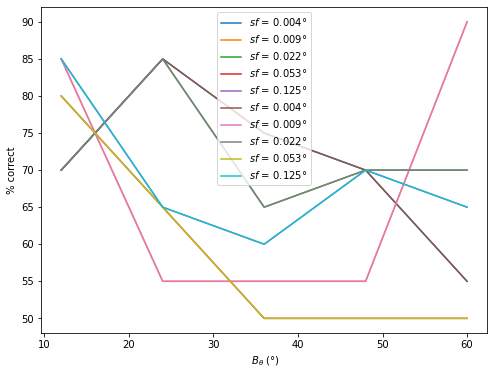

In [8]:
plt.figure(figsize = (8,6)) 
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    correct = data_dict[num]['correct'].reshape((5, 5, 20))
    for i_sf, sf in enumerate(sf_list):
        plt.plot(B_theta_list, correct[:, i_sf, :].mean(axis=-1)*100, label = r'$sf$ = %.3f°' %sf)
    plt.xlabel(r' $B_\theta$ (°)')
    plt.ylabel(r' % correct ')
    plt.legend(loc ='best') ;

## Fit

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="sum")

N_conditions = len(sf_list)*len(B_theta_list)
bias = True
logit0_init, theta0_init, log_wt_init = -np.log(1/.10 - 1), 0.0, np.log(4.)

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0_init, theta0_init, log_wt_init, bias=True):
        super(LogisticRegressionModel, self).__init__()
        if bias:
            self.theta0 = torch.nn.Parameter(theta0_init)
        else:
            self.theta0 = theta0_init
        self.logit0 = torch.nn.Parameter(logit0_init)
        self.log_wt = torch.nn.Parameter(log_wt_init)
        self.do_indep = self.logit0.shape.numel() > 1
        
    def forward(self, theta, i_condition):
        if self.do_indep:
            p0 = torch.sigmoid(self.logit0[i_condition.to(int)])
        else:
            p0 = torch.sigmoid(self.logit0)
            
        theta0 = self.theta0[i_condition.to(int)]
        wt = torch.exp(self.log_wt[i_condition.to(int)])
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-theta0)/wt)
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 12 + 1

def fit_data(logistic_model,
    theta, ind_condition, y,
    learning_rate=learning_rate,
    # batch_size=batch_size,  # previous notebook showed that learning_rate had no influence on performance
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.ByteTensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Theta, Ind_condition, labels = Theta.to(device), Ind_condition.to(device), labels.to(device)        
    
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas)
            
    for epoch in range(int(num_epochs)):
        outputs = logistic_model(Theta, Ind_condition)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {loss.item() /len(theta):.5f}")
            losses = []    
            
     
    logistic_model.eval()
    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.Tensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta, Ind_condition)
    loss = criterion(outputs, labels).item() / len(theta)
    logistic_model.cpu()
    return logistic_model, loss        

In [10]:
bias = False
#bias = True
logit0_init = logit0_init * torch.ones(1)
# indep = logit0_init=logit0_init * torch.ones(int(len(data)/len(B_theta_list)/len(B_sf_list)))
results = {}
for num, data in enumerate(subj_data_list) :
    logistic_model = LogisticRegressionModel(logit0_init * torch.ones(1), theta0_init*torch.ones(N_conditions), torch.log(log_wt_init*torch.ones(N_conditions)), bias=bias)
    logistic_model, loss = fit_data(logistic_model, data_dict[num]['theta'], 
                                    data_dict[num]['conditions'], 
                                    data_dict[num]['response'], verbose=True)
    results[num] = logistic_model
    print("Final loss =", loss)

Iteration: 0 - Loss: 459.70826
Iteration: 128 - Loss: 377.94634
Iteration: 256 - Loss: 324.91759
Iteration: 384 - Loss: 301.96259
Iteration: 512 - Loss: 293.94675
Iteration: 640 - Loss: 290.76500
Iteration: 768 - Loss: 289.20619
Iteration: 896 - Loss: 288.28291
Iteration: 1024 - Loss: 287.66387
Iteration: 1152 - Loss: 287.22121
Iteration: 1280 - Loss: 286.89541
Iteration: 1408 - Loss: 286.65267
Iteration: 1536 - Loss: 286.47064
Iteration: 1664 - Loss: 286.33326
Iteration: 1792 - Loss: 286.22859
Iteration: 1920 - Loss: 286.14774
Iteration: 2048 - Loss: 286.08423
Iteration: 2176 - Loss: 286.03336
Iteration: 2304 - Loss: 285.99181
Iteration: 2432 - Loss: 285.95725
Iteration: 2560 - Loss: 285.92802
Iteration: 2688 - Loss: 285.90297
Iteration: 2816 - Loss: 285.88126
Iteration: 2944 - Loss: 285.86227
Iteration: 3072 - Loss: 285.84553
Iteration: 3200 - Loss: 285.83069
Iteration: 3328 - Loss: 285.81744
Iteration: 3456 - Loss: 285.80558
Iteration: 3584 - Loss: 285.79489
Iteration: 3712 - Loss: 

In [11]:
def npa2str(npa):
    """
    format a numpy array into a string
    """
    return ', '.join(list(map('{:.3f}'.format, npa)))

def get_params(logistic_model, verbose=False):
    theta0_ = logistic_model.theta0.detach().numpy()
    wt_ = torch.exp(logistic_model.log_wt).detach().numpy()
    p0_ = torch.sigmoid(logistic_model.logit0).detach().numpy()
    N_conditions = wt_.shape[0]
    if verbose:
        #for i_condition in range(N_conditions):
        #    print(f'-> i_condition={i_condition}')
        #    if bias:
        #        print(f"theta0 = {theta0_[i_condition]:.3f}")
        #    print(f"slope = {wt_[i_condition]:.3f}")
        if bias:
            print(f"theta0 = {npa2str(theta0_)}")
        print(f"slope = {npa2str(wt_)}")
        print(f"p0 = {npa2str(p0_)}")
    return theta0_, wt_, p0_

for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)

--> observer num 0
slope = 0.111, 2.437, 37.034, 60.447, 30.248, 3.050, 4.126, 32.625, 9.098, 99.374, 1.865, 1.164, 14.335, 14.800, 35.318, 1.120, 6.612, 5.719, 680.842, 27.166, 0.114, 25.110, 65.481, 14.196, 194.044
p0 = 0.220
--> observer num 1
slope = 0.111, 2.437, 37.034, 60.447, 30.248, 3.050, 4.126, 32.625, 9.098, 99.374, 1.865, 1.164, 14.335, 14.800, 35.318, 1.120, 6.612, 5.719, 680.842, 27.166, 0.114, 25.110, 65.481, 14.196, 194.044
p0 = 0.220


--> observer num 0


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

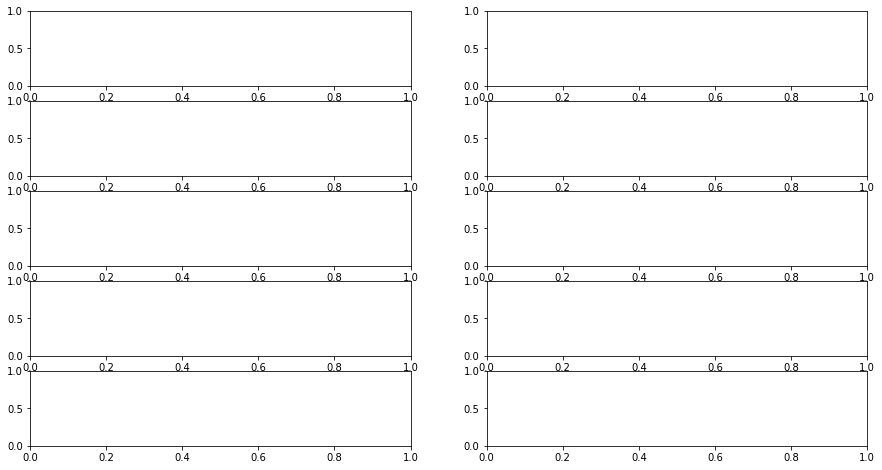

In [12]:
fig, axs = plt.subplots(len(sf_list), len(subj_data_list), figsize=(15, 8))
colors = plt.cm.inferno(np.linspace(.9, .1, len(B_theta_list)))

for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    x_values = np.linspace(-25, 25, 400)

    for i_sf, sf in enumerate(sf_list):
        if len(subj_data_list)>1:
            ax = axs[num]
        else:
            ax = axs

        #colors = plt.cm.inferno(np.linspace(1, .2, len(B_thetas))) #tc colormap

        for i_B_theta, B_theta in enumerate(B_theta_list):
            color = colors[i_B_theta]

            i_condition = i_B_theta + i_sf*len(B_theta_list)
            conditions = i_condition*np.ones_like(x_values)
            y_values = results[num](torch.Tensor(x_values), 
                                      torch.ByteTensor(conditions)).detach().numpy()
            ax.plot(x_values, y_values, color=color, label=r'$B_\theta=%s$' % f'{B_theta:.1f}')

        ax.set_xlabel(r"orientation $\theta$ (°)", fontsize=12)
        ax.set_yticks([0.0, 1.0])
        ax.set_yticklabels(["Left", "Right"], fontsize=12)
        ax.legend(fontsize=11, frameon=False, scatterpoints=6)
        if num==0:  ax.legend(fontsize=11, frameon=False, scatterpoints=6)
        ax.text(14, 0.1, f'sf = {sf:.3f}', fontsize=12)

--> observer num 0
slope = 0.111, 2.437, 37.034, 60.447, 30.248, 3.050, 4.126, 32.625, 9.098, 99.374, 1.865, 1.164, 14.335, 14.800, 35.318, 1.120, 6.612, 5.719, 680.842, 27.166, 0.114, 25.110, 65.481, 14.196, 194.044
p0 = 0.220
--> observer num 1
slope = 0.111, 2.437, 37.034, 60.447, 30.248, 3.050, 4.126, 32.625, 9.098, 99.374, 1.865, 1.164, 14.335, 14.800, 35.318, 1.120, 6.612, 5.719, 680.842, 27.166, 0.114, 25.110, 65.481, 14.196, 194.044
p0 = 0.220


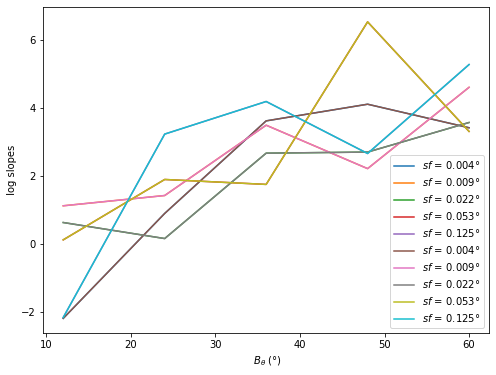

In [13]:
plt.figure(figsize = (8,6)) 

for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)
    for i_sf, sf in enumerate(sf_list):
        wt__ = wt_[(i_sf*len(B_theta_list)):((i_sf+1)*len(B_theta_list))]
        plt.plot(B_theta_list, np.log(wt__), label = r'$sf$ = %.3f°' %sf)
plt.xlabel(r' $B_\theta$ (°)')
plt.ylabel(r' log slopes ')
plt.legend(loc ='best')

--> observer num 0
slope = 0.111, 2.437, 37.034, 60.447, 30.248, 3.050, 4.126, 32.625, 9.098, 99.374, 1.865, 1.164, 14.335, 14.800, 35.318, 1.120, 6.612, 5.719, 680.842, 27.166, 0.114, 25.110, 65.481, 14.196, 194.044
p0 = 0.220
--> observer num 1
slope = 0.111, 2.437, 37.034, 60.447, 30.248, 3.050, 4.126, 32.625, 9.098, 99.374, 1.865, 1.164, 14.335, 14.800, 35.318, 1.120, 6.612, 5.719, 680.842, 27.166, 0.114, 25.110, 65.481, 14.196, 194.044
p0 = 0.220


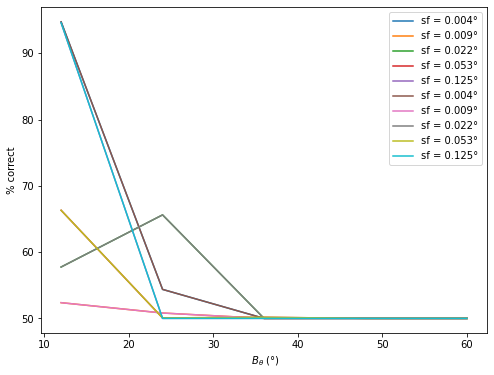

In [19]:
plt.figure(figsize = (8,6)) 
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)
    for i_sf, sf in enumerate(sf_list):
        wt__ = wt_[(i_sf*len(B_theta_list)):((i_sf+1)*len(B_theta_list))]
        correct = .5+ .5*np.exp(-wt__)
        plt.plot(B_theta_list, correct*100, label=f'sf = {sf:.3f}°' )
plt.xlabel(r' $B_\theta$ (°)')
plt.ylabel(r' % correct ')
plt.legend(loc ='best');

--> observer num 0
slope = 0.111, 2.437, 37.034, 60.447, 30.248, 3.050, 4.126, 32.625, 9.098, 99.374, 1.865, 1.164, 14.335, 14.800, 35.318, 1.120, 6.612, 5.719, 680.842, 27.166, 0.114, 25.110, 65.481, 14.196, 194.044
p0 = 0.220
--> observer num 1
slope = 0.111, 2.437, 37.034, 60.447, 30.248, 3.050, 4.126, 32.625, 9.098, 99.374, 1.865, 1.164, 14.335, 14.800, 35.318, 1.120, 6.612, 5.719, 680.842, 27.166, 0.114, 25.110, 65.481, 14.196, 194.044
p0 = 0.220


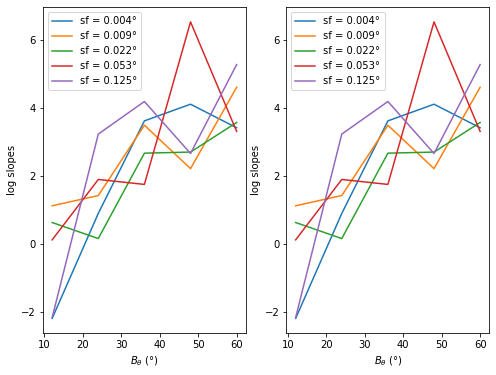

In [20]:
fig, axs = plt.subplots(1, len(subj_data_list), figsize=(8,6)) 
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)
    coef_list = []
    for i_sf, sf in enumerate(sf_list):
        wt__ = wt_[(i_sf*len(B_theta_list)):((i_sf+1)*len(B_theta_list))]
        axs[num].plot(B_theta_list, np.log(wt__), label=f'sf = {sf:.3f}°')
    axs[num].set_xlabel(r'$B_\theta$ (°)')
    axs[num].set_ylabel(r'log slopes')
    axs[num].legend(loc ='best') 
    #axs[num].set_xscale('log')